./example_data/nz_dems/nz_clipped_v22.tif
5427318
27
2


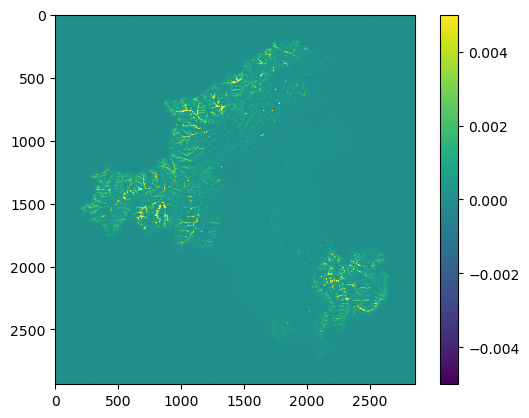

In [1]:
from os.path import exists
import ast
import numpy as np
import sys

sys.path.insert(1, 'lem')
import lem
import multiprocess as mp
import matplotlib.pyplot as plt
import rasterio as rio 

################ -------Params-------- ##################################

dem_folder = './example_data/nz_dems/'
# Modify based on in/out folders
outfolder = './results/NZ1/'
# Number of processors
n_proc = 1
# Number of simulations (parameter sets)
nr = 1

dx_init  = 30.87 #dx for DEM pixels

# Stream power parameters
# Stream power m/n (theta)
theta = 0.45
# Vector of n values.  Currently n ranges from 0-4
ns = np.random.rand(nr) * 4.0 *0+2.14
# The ratio D/k. Currently the prior distribution is log-uniform from 0 to 10
diffus = np.power(10.0, np.random.rand(nr) * 12 + 1) * 1e-11 * 0 
# A_crit values range as a log-uniform distribution
careas = 0*np.power(10.0, np.random.rand(nr) * 3)+0
# diffusion exponents (p) - currently constant
ps = np.zeros(nr) + 1.0
########################################################################


n_basin = 27  # number of basins in octopus
ms = ns * theta  # Vector of m values.  m depends on n

# The erosion rates for each basin, to contain a vector of avg erosion rates
eros1 = [None] * n_basin
# vector of avg slopes in each basin, to compare to octopus slopes
slpsall = np.zeros(n_basin)


def par_ero(i):
    """
    Parallel erosion routine for each DEM basin

    :param i: basin number
    :returns: A; accumulated erosion
    """

    # First run diffusion - we raise the coefficient by 1/p and then raise the whole
    # diffusion rate by p 
    E = lem.diffuse(
        Zi, D=-(diffus[i]**(1.0 / ps[i])), dy=dy1, dx=dx1, dt=1)
    E[E < 0] = 0
    # We only want the erosion part....
    
    E = E**ps[i] # Raise to p
    
    m = ms[i]
    n = ns[i]
    
    # Now add the hillslope erosion and the fluvial erosion
    ero = lem.erode_explicit(
        slps,
        I1,
        s1,
        A1,
        E,
        dx=dx1,
        dy=dy1,
        m=ms[i],
        n=ns[i],
        k=np.zeros(np.shape(slps)) + 2.75e-7,
        carea=careas[i],G=0)

    # This should be zero anyways but just in case...
    ero[slps == 0] = 0
    # Sum erosion downstream = we do it this way so that nodes draining
    # outside of the basin (i.e. on the edge) are not included
    A = lem.acc(I1, s1, init=ero.copy())
    # Calculate the avg erosion per drainage area...
    pl = (A.ravel()[np.argmax(A1.ravel())]) / np.max(A1.ravel())
    return pl, i, ero


for c in range(2, 3):#n_basin):
    demfile = dem_folder + 'nz_clipped_v2{}.tif'.format(str(c))
    print(demfile)

    if exists(demfile):
        dem = rio.open(demfile)
        lat = dem.xy(0, 0)[1]

        dx = np.cos(lat / 180 * np.pi) * dx_init  # dx is dependent on latitude
        f = lem.simple_model()
        f.dx = dx
        f.dy = dx_init

        # We must pad the DEM in order to prevent edge effects
        demz = np.float64(np.squeeze(dem.read()))
        if demz.size < 16:
            continue
        f.set_z(np.pad(demz, pad_width=2))

        # Outlet nodes are at or below 0
        f.BC = np.where(f.Z.transpose().ravel() <= 0)[0]

        # Fill local sinks
        f.sinkfill()

        # calculate local slopes and populate the receiver grid
        f.slp_basin()

        # Build the Fastscape stack
        f.stack()

        # calculate the receiver grid
        f.acc()

        # Get Elevation, corrected
        Zi = f.Z.copy()

        # Get drainage area
        A1 = f.A.copy()

        # Initialize mean erosion rate (per basin) vector
        mnmat = np.zeros((len(ms), 1))

        #Get important values from the pre-processed DEM
        A1 = f.A.copy()
        ny1 = f.ny
        nx1 = f.nx
        I1 = f.I.copy()
        s1 = f.s.copy()
        dy1 = f.dy
        slps = f.slps
        dx1 = dx
        with mp.Pool(n_proc) as procs:
            vals = procs.map(par_ero, np.arange(len(ns))) #Run the erosion model under each set of params
        print(len(eros1))
        print(c)
        plt.imshow(vals[0][2],vmin=-5e-3,vmax=5e-3)
        plt.colorbar()
        eros1[c] = mnmat[list(zip(*vals))[1], 0] = list(zip(*vals))[0] #This is where the erosion rates are saved for each trial
        
        f.acc(slps)#We also calculate the average D8 slope of the basin...
        slpsall[c] = (f.A.ravel()[f.Z.ravel() > 0][np.argmax(A1.ravel()[f.Z.ravel() > 0])]) / np.max(A1.ravel()[f.Z.ravel() > 0])
# if 1:
#     print(eros1)
#     # Mean erosion rates for each model at each basin
#     np.save('{}/eros'.format(outfolder), eros1)
#     # The array of random diffusion rates used
#     np.save('{}/diffu'.format(outfolder), diffus)
#     np.save('{}/ms'.format(outfolder), ms)  # The array of random m values used
#     np.save('{}/ns'.format(outfolder), ns)  # The array of random n values used
#     # The array of random areas used
#     np.save('{}/careas'.format(outfolder), careas)
#     # Calculated avg slopes of each basin
#     np.save('{}/slps2'.format(outfolder), slpsall)
#     np.save('{}/dns'.format(outfolder), ps)


In [2]:
np.sum(vals[0][2][vals[0][2]>0])/np.sum(vals[0][2][vals[0][2]<0])

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_1068/391302922.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  np.sum(vals[0][2][vals[0][2]>0])/np.sum(vals[0][2][vals[0][2]<0])


inf

In [3]:
Z = np.load("../NZ/topo.npy")
f = lem.simple_model()
f.set_z(Z)
f.dx = 350
f.dy = 450
f.dt=1
f.n=2.14
f.m=f.n*.45
f.k = np.zeros(np.shape(f.k))+2.5e-7
f.sinkfill()
f.slp()
f.stack()
f.acc()
f.A[f.Z<0]=0
Zi = f.Z.copy()
f.erode()



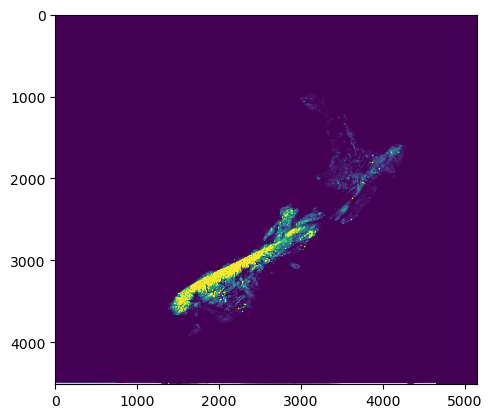

In [4]:
ero=Zi-f.Z
plt.imshow(ero,vmax=1e-2)


In [16]:
np.max(ero)

44.480121872366254